In [1]:
def transform_skewed_metrics(df, columns, skew_threshold=1.0):
    """
    Applies log1p or Yeo-Johnson transformation to columns with skewness above the threshold.

    - log1p is used if all values > 0
    - Yeo-Johnson is used if values include 0 or negatives

    Returns:
        DataFrame with added transformed columns.
    """
    transformed_df = df.copy()

    for col in columns:
        col_data = df[col].dropna()
        if abs(skew(col_data)) <= skew_threshold:
            continue  # Skip transformation

        if (col_data > 0).all():
            transformed_df[col + '_log'] = np.log1p(df[col])
        else:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed = transformer.fit_transform(df[col].values.reshape(-1, 1)).flatten()
            transformed_df[col + '_yj'] = transformed

    return transformed_df

def select_best_transformed_version(df):
    selected_cols = []

    # Get all base column names (before _log or _yj)
    base_cols = set(col.replace('_log', '').replace('_yj', '') for col in df.columns)

    for base in base_cols:
        log_col = base + '_log'
        yj_col = base + '_yj'

        if log_col in df.columns:
            selected_cols.append(log_col)
        elif yj_col in df.columns:
            selected_cols.append(yj_col)
        elif base in df.columns:
            selected_cols.append(base)
        # else: skip — no usable version of this metric

    return df[selected_cols].copy()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import skew

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from PlottingFunctions import *

## Read dataframe of results for all gauges

In [3]:
all_events =[]
for file in os.listdir("../DanishRainData_Outputs/5mins/"):
    df = pd.read_csv(f"../DanishRainData_Outputs/5mins/{file}")
    df['event_num']=range(0, len(df))
    all_events.append(df)
all_events_df = pd.concat(all_events)   

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (83,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Remove events which are too small

In [4]:
print(len(all_events_df))
all_events_df = all_events_df[all_events_df['total_precip']>4].copy()
print(len(all_events_df))

539546
516453


### Remove normalisations we're not interested in (rn)

In [5]:
print(len(all_events_df.columns))
columns_to_drop = [col for col in all_events_df.columns if '_norm' in col or '_dblnorm' in col or 'DMC_100' in col or 'DMC_10' in col]
all_events_df.drop(columns=columns_to_drop, inplace=True)
print(len(all_events_df.columns))

189
69


In [6]:
all_events_df.reset_index(inplace=True, drop=True)

### Remove columns we're not interested in (rn)

In [7]:
del all_events_df['min_intensity']
del all_events_df['BSC']
del all_events_df['duration']
del all_events_df['total_precip']
del all_events_df['m1'], all_events_df['m2'], all_events_df['m3'], all_events_df['m4'], all_events_df['m5']
del all_events_df['time_to_peak']
# del all_events_df['BSC_DMC']
# del all_events_df['mean_intensity_DMC']
# del all_events_df['min_intensity_DMC']

### Delete problematic (np.nan) columns

In [8]:
cols_to_keep = all_events_df.columns
cols_to_del = ['min_intensity', 'min_intensity_DMC_10', 
               'min_intensity', 'min_intensity_DMC_10', # doesnt make sense, as for DMC it is always 0.1
               'frac_q1', 'frac_q2', 'frac_q3', 'frac_q4', ## loads have NAN when we don't interpolate
               'frac_q1_DMC_10', 'frac_q2_DMC_10', 'frac_q3_DMC_10', 'frac_q4_DMC_10',   ## loads have NAN when we don't interpolate
              'heaviest_half', 'heaviest_half_DMC_10', # lots of events dont have a 'run' over threshold
              ]

cols_to_keep = [x for x in cols_to_keep if x not in cols_to_del]  

all_events_df = all_events_df[cols_to_keep]

In [9]:
# Find columns with nan for 60 mins
columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
print("Columns with at least one NaN value:")
print(columns_with_nan)

Columns with at least one NaN value:
['asymm_d', 'Event Loading', 'lorentz_asymetry']


In [10]:
# # Find indices of rows with any NaNs in the 60-minute data
bad_indices = all_events_df[all_events_df.isnull().any(axis=1)].index
len(bad_indices)
# Drop rows at these indices from all dataframes
all_events_df = all_events_df.drop(index=bad_indices)

del all_events_df['event_num']
all_events_df.reset_index(drop=True, inplace=True)

# Recheck for NANS
columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
print("Columns with at least one NaN value:")
print(columns_with_nan)

Columns with at least one NaN value:
[]


## Check skewness of variables

In [11]:
metric_columns = all_events_df.columns
metric_columns = metric_columns.drop(['gauge_num', "start_time", "end_time"])
all_events_df = all_events_df[metric_columns]

## Transform variables

In [12]:
transformed_all_events_df = transform_skewed_metrics(all_events_df, metric_columns)
transformed_all_events_df = select_best_transformed_version(transformed_all_events_df)
# transformed_all_events_df = all_events_df

## Standardise Data

In [13]:
metric_columns = transformed_all_events_df.columns
standard_scaler = MinMaxScaler()
transformed_scaled = standard_scaler.fit_transform(transformed_all_events_df[metric_columns])
# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
transformed_scaled = pd.DataFrame(transformed_scaled, columns=metric_columns)

In [14]:
# metric_base_names = {col.replace(suffix, '') for col in all_events_df.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

In [17]:
# spearmansr_ls = []
# metric_names = []
# suffixes = ['', '_log', '_yj']

# for i, base_name in enumerate(metric_columns):

#         if col1 in scaled_all_events_df.columns and col2 in scaled_all_events_df.columns:
#             x = scaled_all_events_df[col1]
#             y = scaled_all_events_df[col2]
            
#             pearsonsr_ls.append(pearsonr(x, y)[0])
#             spearmansr_ls.append(spearmanr(x, y)[0])
#             metric_names.append(base_name + suffix)
#             found_pair = True
#             break  # stop after finding first matching suffix pair
            
#     if not found_pair:
#         print(f"No matching pair found for metric '{base_name}' with any suffix")

## Create correlation matrix

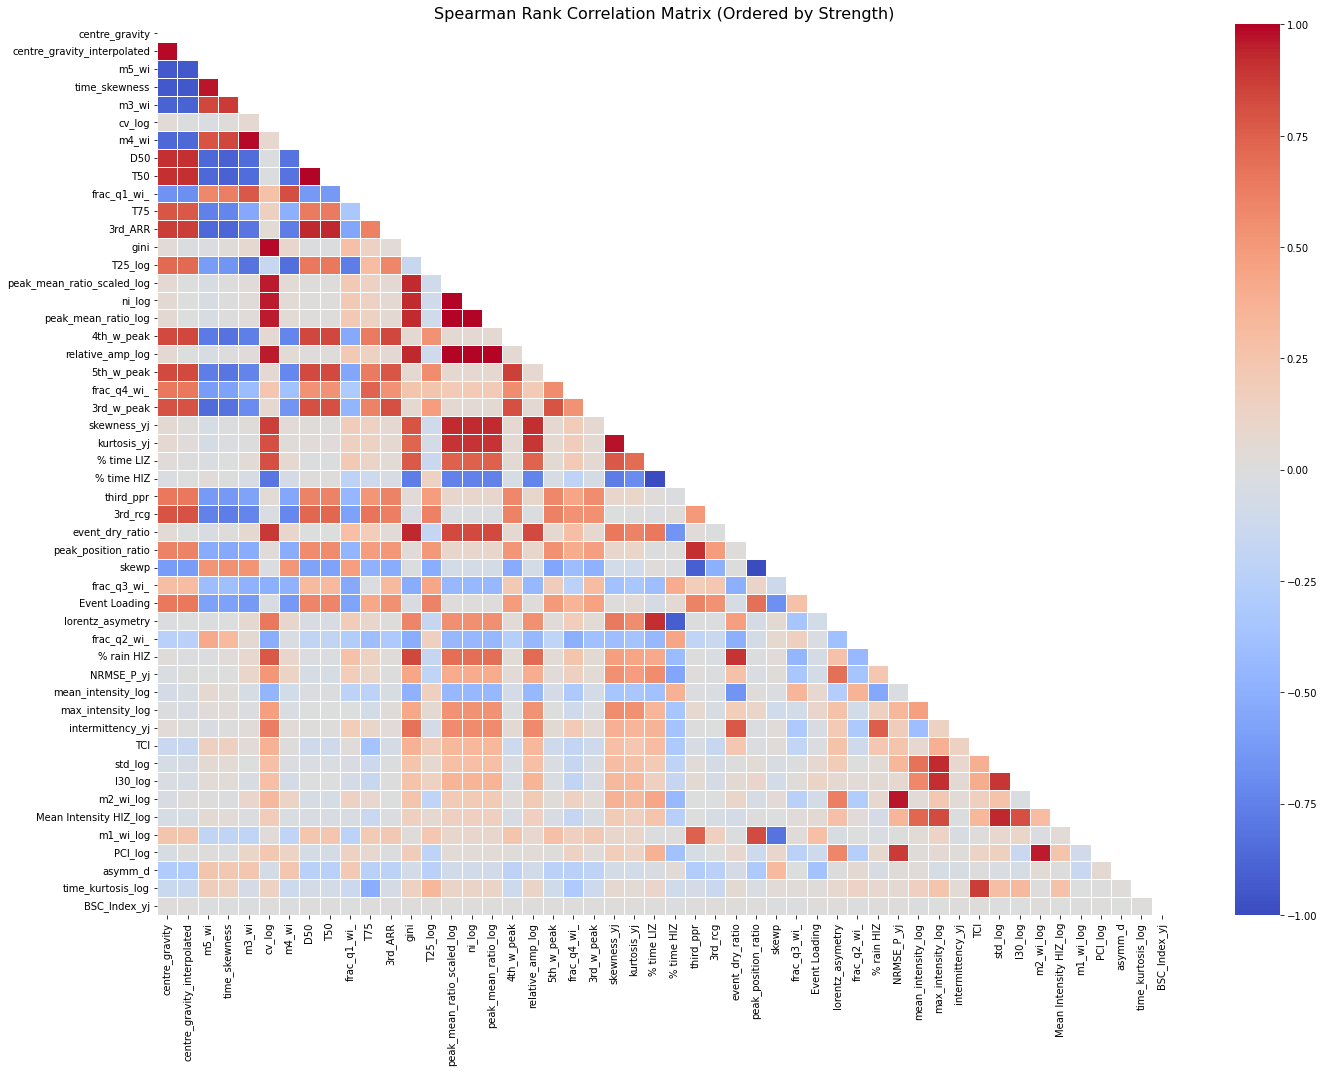

In [15]:
spearman_corr = transformed_scaled.corr(method='spearman')
# Reorder based on absolute total Spearman correlation strength
spearman_strength = spearman_corr.abs().sum().sort_values(ascending=False)
ordered_columns = spearman_strength.index.tolist()
reordered_spearman = spearman_corr.loc[ordered_columns, ordered_columns]

# Plot Spearman heatmap
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(reordered_spearman, dtype=bool))
sns.heatmap(
    reordered_spearman, mask=mask, cmap='coolwarm',
    annot=False, fmt=".2f", linewidths=0.5, cbar=True,
    xticklabels=True, yticklabels=True, annot_kws={"size": 12}, vmin=-1, vmax=1)

plt.title("Spearman Rank Correlation Matrix (Ordered by Strength)", fontsize=16)
plt.tight_layout()
plt.show()


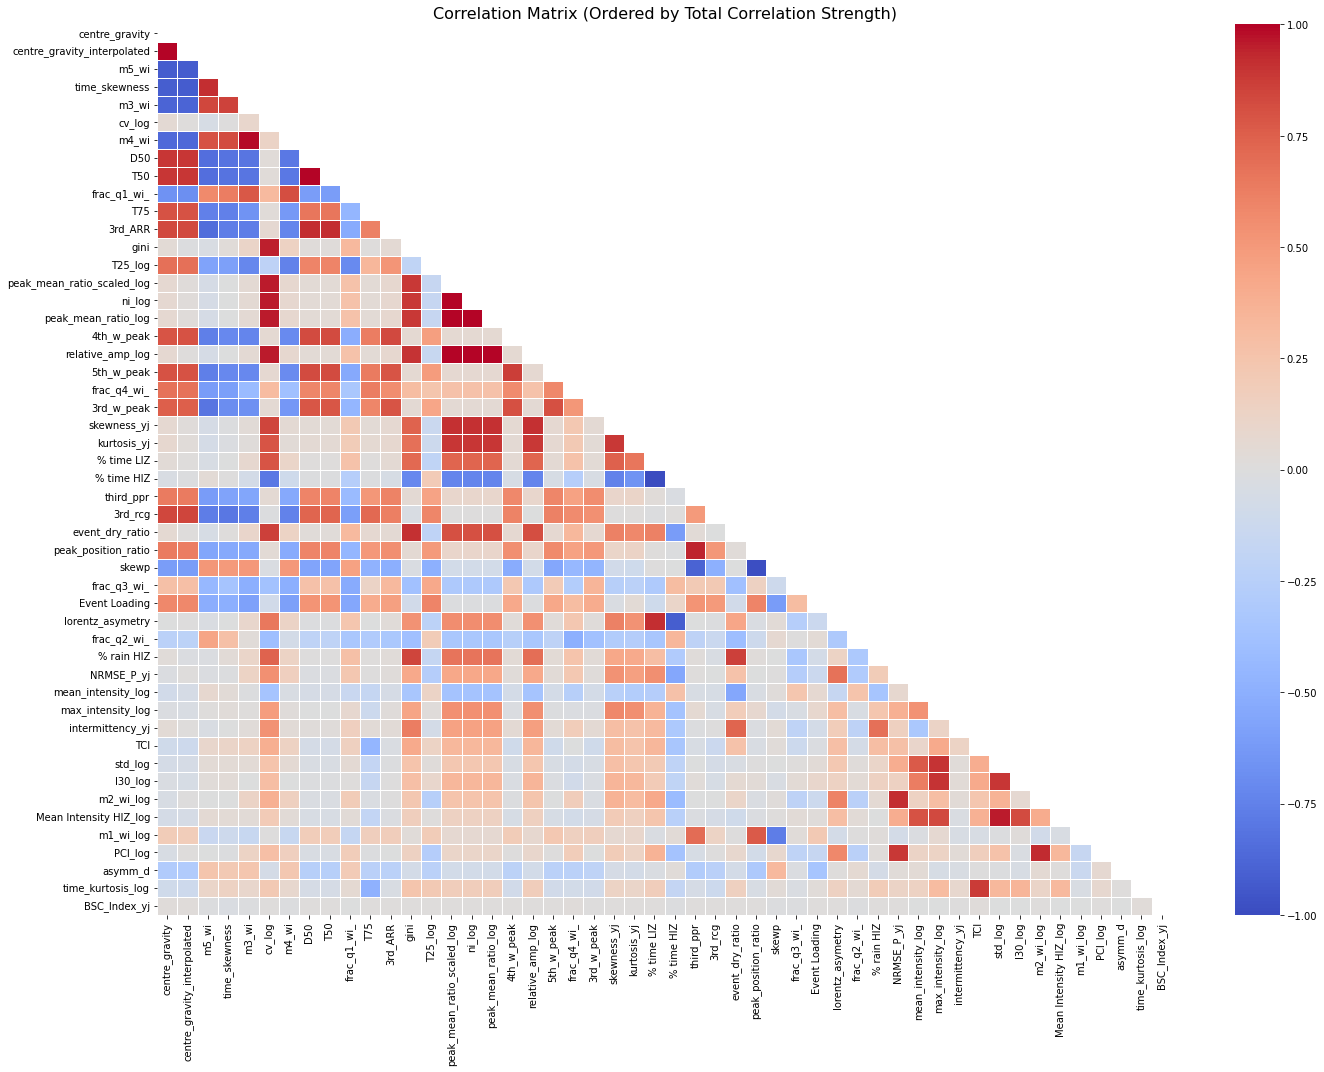

In [185]:
correlation_matrix_raw_pearson = transformed_scaled.corr(method = 'pearson')
# corr_strength = correlation_matrix_raw_pearson.abs().sum().sort_values(ascending=False)

# Reorder both rows and columns
# ordered_columns = corr_strength.index.tolist()
reordered_corr = correlation_matrix_raw.loc[ordered_columns, ordered_columns]

# Plot
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(reordered_corr, dtype=bool))
sns.heatmap(
    reordered_corr, mask=mask, cmap='coolwarm',
    annot=False, fmt=".2f", linewidths=0.5, cbar=True,
    xticklabels=True, yticklabels=True, annot_kws={"size": 16}, vmin=-1, vmax=1)

plt.title("Correlation Matrix (Ordered by Total Correlation Strength)", fontsize=16)
plt.tight_layout()
plt.show()

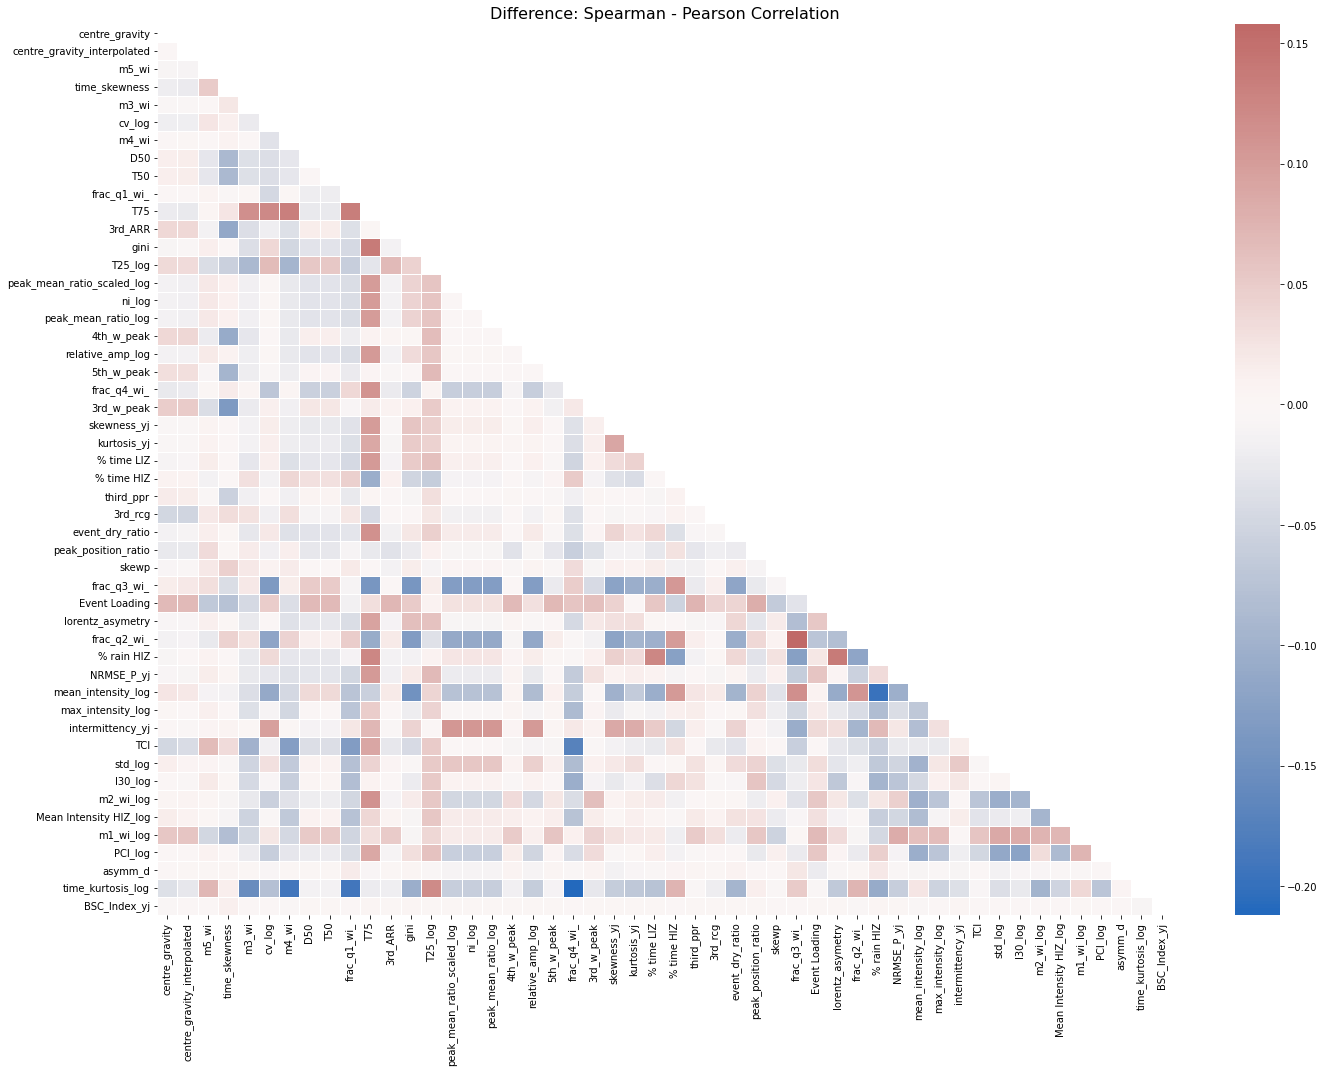

In [188]:
diff_matrix = reordered_spearman - reordered_corr

plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
sns.heatmap(
    diff_matrix, mask=mask, cmap='vlag', center=0,
    annot=False, fmt=".2f", linewidths=0.5, cbar=True,
    xticklabels=True, yticklabels=True)

plt.title("Difference: Spearman - Pearson Correlation", fontsize=16)
plt.tight_layout()
plt.show()


## Cluster analysis

In [149]:
data_for_clustering = transformed_scaled.T  # Transpose so rows = metrics, columns = events

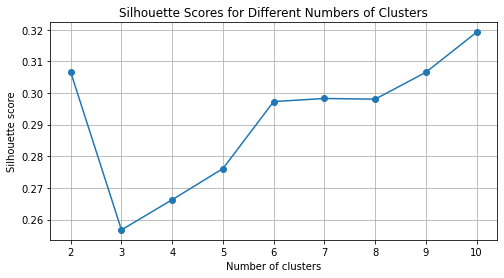

In [150]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2, 11))
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clusterer.fit_predict(data_for_clustering)
    score = silhouette_score(data_for_clustering, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

In [164]:
names = data_for_clustering.index
names_types = []
# Group by cluster and build the display string
for name in names:
    name = name.replace("_yj", "")
    name = name.replace("_log", "")
    names_type =f"{name} ({dict_types[name]})"
    names_types.append(names_type)

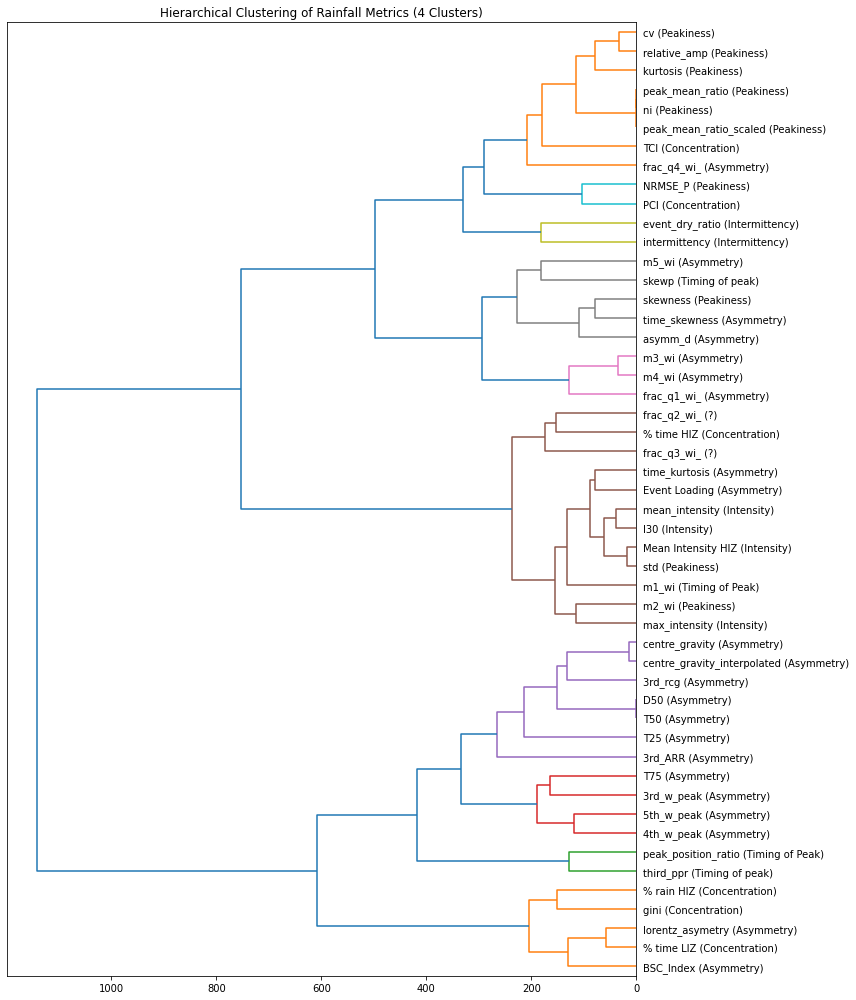

In [172]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Transpose so metrics are rows
data_for_clustering = transformed_scaled.T

# Hierarchical clustering
Z = linkage(data_for_clustering, method='ward')

# Get cluster labels for 4 clusters
n_clusters = 10
cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')

# Create DataFrame for cluster membership
cluster_df = pd.DataFrame({
    'Metric': data_for_clustering.index,
    'Cluster': cluster_labels
}).set_index('Metric')

# Get color threshold for dendrogram
threshold = Z[-(n_clusters - 1), 2]

# Plot dendrogram with color-coded branches
plt.figure(figsize=(12, 14))
dendrogram(
    Z,
    labels=names_types,
    leaf_rotation=0,
    leaf_font_size=10,
    orientation='left',
    color_threshold=threshold
)
plt.title('Hierarchical Clustering of Rainfall Metrics (4 Clusters)')
plt.tight_layout()
plt.show()

### Kmeans clustering

In [167]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=10, random_state=0, batch_size=10000)
labels = kmeans.fit_predict(data_for_clustering)
# Add labels to your original dataframe for inspection or plotting
data_for_clustering['cluster_label'] = labels
data_for_clustering.index= names_types

In [168]:
# Assuming you already have cluster_df with 'Cluster' as column and metric index
# Sort by cluster to group metrics nicely
cluster_df_sorted = data_for_clustering.sort_values('cluster_label')

# Group metrics by cluster
grouped = cluster_df_sorted.groupby('cluster_label').apply(lambda x: list(x.index))

# Find the max number of metrics in any cluster for row alignment
max_len = max(len(metrics) for metrics in grouped)

# Pad each cluster list with empty strings to equalize length
for cluster in grouped.index:
    metrics = grouped[cluster]
    grouped[cluster] = metrics + [''] * (max_len - len(metrics))

# Convert to DataFrame: columns = clusters, rows = metrics
cluster_table = pd.DataFrame(dict(zip(
    [f'Cluster {c}' for c in grouped.index], 
    [grouped[c] for c in grouped.index])))

cluster_table

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
0,intermittency (Intermittency),time_kurtosis (Asymmetry),5th_w_peak (Asymmetry),PCI (Concentration),skewp (Timing of peak),centre_gravity (Asymmetry),peak_mean_ratio_scaled (Peakiness),peak_position_ratio (Timing of Peak),gini (Concentration),3rd_ARR (Asymmetry)
1,event_dry_ratio (Intermittency),frac_q2_wi_ (?),T75 (Asymmetry),time_skewness (Asymmetry),m3_wi (Asymmetry),T50 (Asymmetry),ni (Peakiness),third_ppr (Timing of peak),lorentz_asymetry (Asymmetry),
2,,m2_wi (Peakiness),4th_w_peak (Asymmetry),asymm_d (Asymmetry),frac_q1_wi_ (Asymmetry),centre_gravity_interpolated (Asymmetry),TCI (Concentration),,BSC_Index (Asymmetry),
3,,m1_wi (Timing of Peak),3rd_w_peak (Asymmetry),skewness (Peakiness),m4_wi (Asymmetry),3rd_rcg (Asymmetry),kurtosis (Peakiness),,% rain HIZ (Concentration),
4,,Mean Intensity HIZ (Intensity),,NRMSE_P (Peakiness),m5_wi (Asymmetry),T25 (Asymmetry),relative_amp (Peakiness),,% time LIZ (Concentration),
5,,std (Peakiness),,,,D50 (Asymmetry),cv (Peakiness),,,
6,,mean_intensity (Intensity),,,,,frac_q4_wi_ (Asymmetry),,,
7,,% time HIZ (Concentration),,,,,peak_mean_ratio (Peakiness),,,
8,,I30 (Intensity),,,,,,,,
9,,max_intensity (Intensity),,,,,,,,


## PCA

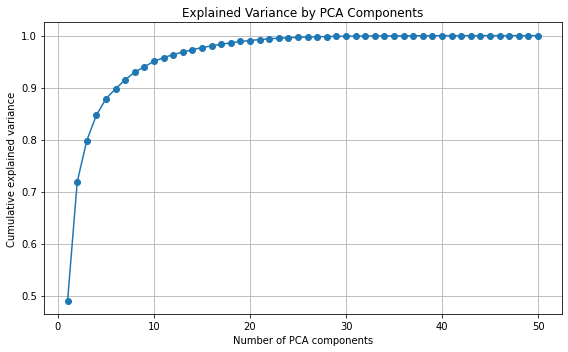

In [173]:
# Assuming all_events_df is already scaled
pca = PCA()
metrics_df = transformed_scaled.T
pca.fit(metrics_df)

explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.tight_layout()
plt.show()

n_clusters = 2, silhouette score = 0.3883
n_clusters = 3, silhouette score = 0.3599
n_clusters = 4, silhouette score = 0.3916
n_clusters = 5, silhouette score = 0.4024
n_clusters = 6, silhouette score = 0.4311
n_clusters = 7, silhouette score = 0.4400
n_clusters = 8, silhouette score = 0.4355
n_clusters = 9, silhouette score = 0.4284
n_clusters = 10, silhouette score = 0.4161


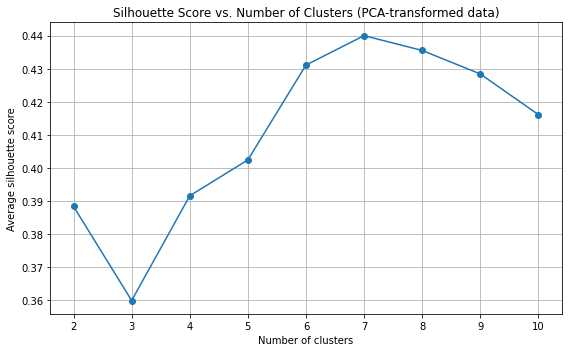

In [174]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Apply PCA
pca = PCA(n_components=4)  # Use enough components to retain >80-90% variance
X_pca = pca.fit_transform(metrics_df)

# 2. Try multiple cluster counts and calculate silhouette scores
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"n_clusters = {n_clusters}, silhouette score = {silhouette_avg:.4f}")

# 3. Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (PCA-transformed data)")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [178]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import seaborn as sns
import pandas as pd

# Transpose so each row is a metric
metrics_df = transformed_scaled.T

# Apply PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(metrics_df)

# Create PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=metrics_df.index)

# KMeans clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
pca_df['cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# # Stronger color map
# colors = sns.color_palette("Set1", n_colors=n_clusters)

# # 3D plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for i, row in pca_df.iterrows():
#     ax.scatter(row['PC1'], row['PC2'], row['PC3'], 
#               color=colors[int(row['cluster'])], s=60, edgecolor='k')
#     ax.text(row['PC1'], row['PC2'], row['PC3'], i, fontsize=8, color='black')

# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# plt.title("3D PCA Projection of Metrics with Cluster Labels")
# plt.tight_layout()
# plt.show()


In [179]:
# Group metrics by cluster label
for cluster_id in sorted(pca_df['cluster'].unique()):
    print(f"\nCluster {cluster_id}:")
    print(", ".join(pca_df[pca_df['cluster'] == cluster_id].index))


Cluster 0:
event_dry_ratio, time_skewness, skewness_yj, NRMSE_P_yj

Cluster 1:
max_intensity_log, frac_q3_wi_, Event Loading, I30_log, mean_intensity_log, std_log, Mean Intensity HIZ_log, m1_wi_log, m2_wi_log, frac_q2_wi_, time_kurtosis_log

Cluster 2:
peak_position_ratio, 3rd_rcg, centre_gravity_interpolated, centre_gravity, T50, D50

Cluster 3:
BSC_Index_yj, % rain HIZ

Cluster 4:
3rd_w_peak, 4th_w_peak, T25_log, T75, 5th_w_peak

Cluster 5:
skewp, m5_wi

Cluster 6:
% time LIZ, gini, lorentz_asymetry, asymm_d

Cluster 7:
frac_q1_wi_, m4_wi, m3_wi

Cluster 8:
intermittency_yj, ni_log, relative_amp_log, cv_log, % time HIZ, peak_mean_ratio_log, peak_mean_ratio_scaled_log, PCI_log, kurtosis_yj, TCI, frac_q4_wi_

Cluster 9:
third_ppr, 3rd_ARR


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # 1. Define your groups clearly
# groups = {
#     "Peakiness": [
#         'm3', 'm4', 'm5', 'D50', 'T25', 'T75', 
#         'centre_gravity_interpolated', 'time_skewness', 'time_kurtosis'
#     ],
#     "Asymmetry": [
#         '3rd_com', '3rd_ARR', 'Event Loading', 
#         'lorentz_asymetry', 'BSC_Index'
#     ],
#     "Concentration": [
#         'peak_mean_ratio', 'kurtosis', 'skewness', 'std', 'cv', 
#         'NRMSE_P', 'TCI', 'PCI', 'gini', '% time HIZ', 
#         '% time LIZ', '% rain HIZ'
#     ]
# }

# # 2. Reorder the DataFrame columns based on the groups
# ordered_metrics = sum(groups.values(), [])  # Flatten the list of lists
# all_events_df_reordered = all_events_df[ordered_metrics]

# # 3. Compute correlation matrix
# correlation_matrix_reordered = all_events_df_reordered.corr()

# # 4. Plot heatmap with improved group separation and labeling
# plt.figure(figsize=(20, 15))
# mask = np.triu(np.ones_like(correlation_matrix_reordered, dtype=bool))

# # Group separators
# group_sizes = [len(groups[g]) for g in groups]
# group_cuts = np.cumsum([0] + group_sizes)

# for cut in group_cuts[1:-1]:  # Draw lines between groups (exclude first/last)
#     plt.axhline(cut, color='black', linewidth=3, zorder=10)
#     plt.axvline(cut, color='black', linewidth=3, zorder=10)

# # Plot heatmap
# sns.heatmap(
#     correlation_matrix_reordered, mask=mask, cmap='coolwarm',
#     annot=True, fmt=".2f", linewidths=0.5, cbar=True,
#     xticklabels=True, yticklabels=True, annot_kws={"size": 12},
#     vmin=-1, vmax=1
# )

# # Improve layout and label size
# plt.xticks(rotation=90, fontsize=14)
# plt.yticks(rotation=0, fontsize=14)
# plt.title("Correlation Matrix of Rainfall Metrics by Category", fontsize=18, pad=20)
# plt.tight_layout()
# plt.show()

# # 5. Quantify within-group and between-group correlations
# def mean_abs_corr(metrics1, metrics2, corr_matrix):
#     values = corr_matrix.loc[metrics1, metrics2].values
#     if metrics1 == metrics2:
#         mask = ~np.eye(len(metrics1), dtype=bool)
#         return np.mean(np.abs(values[mask]))
#     else:
#         return np.mean(np.abs(values))

# print("\n🔍 Within-group correlations:")
# for group_name, metrics in groups.items():
#     score = mean_abs_corr(metrics, metrics, correlation_matrix_reordered)
#     print(f"  {group_name:<15}: {score:.2f}")

# print("\n🔀 Between-group correlations:")
# group_names = list(groups.keys())
# for i in range(len(group_names)):
#     for j in range(i+1, len(group_names)):
#         g1, g2 = group_names[i], group_names[j]
#         score = mean_abs_corr(groups[g1], groups[g2], correlation_matrix_reordered)
#         print(f"  {g1:<10} vs {g2:<10}: {score:.2f}")


In [ ]:
# def plot_correlation_matrix(corr_matrix, ax, cbar, title):

#     # Mask the upper triangle
#     mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

#     # Draw group separators (e.g., after every 3 variables)
#     group_sizes = [0, 9, 5]  # Adjust based on your actual groupings
#     group_cuts = np.cumsum(group_sizes)

#     for cut in group_cuts[:-1]:  # Don't draw line after the last group
#         plt.axhline(cut, color='black', linewidth=1)
#         plt.axvline(cut, color='black', linewidth=1)

#     # Create heatmap with annotations and larger labels
#     sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", 
#                 linewidths=0.5, cbar=cbar, xticklabels=True, yticklabels=True, annot_kws={"size": 12},
#                 vmin=-1, vmax=1, ax=ax)  # Enforce colorbar range from -1 to 1

#     # Increase the font size for axis labels
# #     ax.set_xticks(rotation=90, fontsize=14)  # Rotate x-axis labels and increase font size
# #     ax.set_yticks(rotation=0, fontsize=14)   # Increase y-axis label font size
#     ax.set_title(title)
# #     # Improve layout
# #     plt.tight_layout()

# fig,axs =plt.subplots(ncols=2, nrows = 2,  figsize=(20,15))
# plot_correlation_matrix(correlation_matrix_asymmetry, axs[0,0], False, 'Asymmetry')
# plot_correlation_matrix(correlation_matrix_concentration, axs[0,1], True, 'Concentration')
# plot_correlation_matrix(correlation_matrix_peakiness, axs[1,0], False, 'Peakiness')
# # plot_correlation_matrix(correlation_matrix_concentration, axs[1], True)